In [1]:
#Librairies and packages needed to run the application
from deepchain.models.utils import confusion_matrix_plot, model_evaluation_accuracy, confusion_matrix
from sklearn.model_selection import train_test_split
from biotransformers import BioTransformers
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
import random
import os
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional,Conv1D,MaxPooling1D, InputLayer
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from matplotlib import pyplot



2021-11-05 16:09:11.055378: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2021-11-05 16:09:11.055428: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/opt/conda/lib/python3.7/site-packages/horovod/common/util.py:258: UserWarning: Framework pytorch installed with version 1.8.1+cu102 but found version 1.8.1+cu111.
             This can result in unexpected behavior including runtime errors.
             Reinstall Horovod using `pip install --no-cache-dir` to build with the new version.
  warnings.warn(get_version_mismatch_message(name, version, installed_version))


In [2]:
#Fix the seed to avoid stochasticity 
SEED = 45
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.get_logger().setLevel(logging.ERROR)

**Run the application on BRCA1 dataset**

In [3]:
#import dataset
def create_dataset (file_path):
    data=pd.read_csv(file_path, header=None)
    data.columns = ['Data_{}'.format(int(i)+1) for i in data.columns]
    data.columns = [*data.columns[:-1], 'labels']
    return data
data = create_dataset('/home/k.benrayana/PathogenicAaMutations/data/BRCA1_CTerDom.csv') #BRCA1 dataset

data


,Data_1,Data_2,Data_3,Data_4,Data_5,Data_6,Data_7,Data_8,Data_9,Data_10,...,Data_217,Data_218,Data_219,Data_220,Data_221,Data_222,Data_223,Data_224,Data_225,labels
0,R,V,S,R,E,K,P,E,L,T,...,C,Q,E,L,D,T,Y,L,I,0
1,G,V,S,R,E,K,P,E,L,T,...,C,Q,E,L,D,T,Y,L,I,0
2,C,V,S,R,E,K,P,E,L,T,...,C,Q,E,L,D,T,Y,L,I,0
3,N,V,S,R,E,K,P,E,L,T,...,C,Q,E,L,D,T,Y,L,I,0
4,R,V,S,R,E,K,P,E,L,T,...,C,Q,E,L,D,T,Y,L,I,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,S,V,S,R,E,K,P,E,L,T,...,C,Q,E,L,D,T,Y,L,R,0
1821,S,V,S,R,E,K,P,E,L,T,...,C,Q,E,L,D,T,Y,L,I,0
1822,S,V,S,R,E,K,P,E,L,T,...,C,Q,E,L,D,T,Y,L,M,0
1823,S,V,S,R,E,K,P,E,L,T,...,C,Q,E,L,D,T,Y,L,I,0


In [4]:
#prepare the sequences and labels

d = np.array(data)
sample_len = d.shape[0] # number of protein sequences in the whole dataset
time_len = d.shape[1]-1 #  length of the protein seq in the whole  dataset
#Hydrophilic coding vocabulary for hydrophobicity representation
vocab1 = {'A': 1.8, 'R':-4.5,'N':-3.5,'D':-3.5,'C':2.5,'Q':-3.5,'E':-3.5,'G':-0.4,'H' :-3.2,'I':4.5,
         'L':3.8,'K':-3.9,'M':1.9,'F':2.8,'P':-1.6,'S':-0.8,'T':-0.7,'W':-0.9,'Y':-1.3,'V':4.2,'X':-3.5,'*':-100}
#Mutation type Benign:0; Pathogenic:1
tags = {'0':0, '1':1}
#prepare data splits for embeddings + hydrophbicity index
data=np.array(data)
data_len = data.shape[0]
data_seqlen = data.shape[1] -1

sequences = data[:, 0:data_seqlen]
labels = data[:, data_seqlen]

#replace each Aa of sequences with hydrophobicity index
Aa_hydro = [[vocab1[word] for word in sentence] for sentence in sequences]
Aa_hydro = np.array(Aa_hydro).reshape(data_len,data_seqlen)
Aa_hydro
#Prepare labels reshape (data_len, 1)
labels = labels.reshape(data_len,1)
#compute embeddings of all sequences
transformer = BioTransformers(backend="protbert_bfd", device="cuda")
embeddings= transformer.compute_embeddings(sequences)["mean"]

/home/k.benrayana/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: device is deprecated; use num_gpus
Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████| 1825/1825 [03:32<00:00,  8.58it/s]


In [5]:
labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=object)

In [6]:
Aa_hydro

array([[-4.5,  4.2, -0.8, ..., -1.3,  3.8,  4.5],
       [-0.4,  4.2, -0.8, ..., -1.3,  3.8,  4.5],
       [ 2.5,  4.2, -0.8, ..., -1.3,  3.8,  4.5],
       ...,
       [-0.8,  4.2, -0.8, ..., -1.3,  3.8,  1.9],
       [-0.8,  4.2, -0.8, ..., -1.3,  3.8,  4.5],
       [-0.8,  4.2, -0.8, ..., -1.3,  3.8,  4.5]])

In [7]:
embeddings

array([[ 0.04196068,  0.03266414, -0.01854421, ...,  0.00027139,
        -0.0157806 , -0.00155506],
       [ 0.0397848 ,  0.03253024, -0.01980862, ..., -0.00053349,
        -0.016669  , -0.00095534],
       [ 0.04093608,  0.03347157, -0.01813594, ..., -0.00111411,
        -0.01706131, -0.00024522],
       ...,
       [ 0.03983774,  0.03178754, -0.01925019, ..., -0.0006728 ,
        -0.01674363, -0.00241928],
       [ 0.03891021,  0.03094034, -0.01758424, ..., -0.00151938,
        -0.01747637, -0.00104113],
       [ 0.03891021,  0.03094034, -0.01758424, ..., -0.00151938,
        -0.01747637, -0.00104113]], dtype=float32)

In [8]:
#embedding representation  with hydrophibicity encoder
sequences_hydro = np.concatenate((embeddings,Aa_hydro),axis=1)


In [9]:
sequences_hydro


array([[ 0.04196068,  0.03266414, -0.01854421, ..., -1.3       ,
         3.8       ,  4.5       ],
       [ 0.0397848 ,  0.03253024, -0.01980862, ..., -1.3       ,
         3.8       ,  4.5       ],
       [ 0.04093608,  0.03347157, -0.01813594, ..., -1.3       ,
         3.8       ,  4.5       ],
       ...,
       [ 0.03983774,  0.03178754, -0.01925019, ..., -1.3       ,
         3.8       ,  1.9       ],
       [ 0.03891021,  0.03094034, -0.01758424, ..., -1.3       ,
         3.8       ,  4.5       ],
       [ 0.03891021,  0.03094034, -0.01758424, ..., -1.3       ,
         3.8       ,  4.5       ]])

In [10]:
#split data 70% training set 15% validation set 15 % test or evaluation set
over = RandomOverSampler()  # balance training set

def split_dataset(sequences, labels):
    x_train, x_test, y_train, y_test = train_test_split(sequences, np.array(labels), test_size=0.15, random_state=1)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.176, random_state=2) 
    y_train=y_train.astype(float).reshape(y_train.size,1)
    y_test=y_test.astype(float).reshape(y_test.size,1)
    y_val=y_val.astype(float).reshape(y_val.size,1)
    x_train, y_train = over.fit_resample(x_train, y_train)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [11]:
#reshape final representation to 3D as an input for CNN/BiLSTM classifier 
def model_input(x_train, x_test, x_val):

    x_train=np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test=np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    x_val=np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))
    return x_train, x_test, x_val

In [12]:
x_train, y_train, x_test, y_test, x_val, y_val=split_dataset(sequences_hydro, labels) #split dataset to train/validation/test

In [13]:
x_train, x_test, x_val=model_input(x_train, x_test, x_val)


In [14]:
#verify if the train set is balanced
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))


{0.0: 1005, 1.0: 1005}

In [15]:
#Classifier CNN/BiLSTM
input_shape = x_train.shape[2] # shape of input: 1024 (protbert_bfd embeddings) + size of protein sequence (BRCA1: 225/PTEN: 403)
timesteps = x_train.shape[0] # number of protein sequences
model = Sequential()
model.add(InputLayer(input_shape=(timesteps, input_shape)))
model.add(Conv1D(filters=128, kernel_size=1, activation='relu')) # expected input data shape: (batch_size, timesteps, input_shape)
model.add(MaxPooling1D(pool_size=3, padding="same"))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dense(1, activation='sigmoid'))
bce_loss = tf.keras.losses.BinaryCrossentropy() #BCE loss function
accuracy = tf.keras.metrics.BinaryAccuracy() # Binary Accuracy (expressed in the [0,1] interval)
optimizer = tf.optimizers.Adam(learning_rate = 0.001) #Adam optimizer
model.compile(optimizer, bce_loss, accuracy)  
model.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=300, batch_size=32) #Training of the model


2021-11-05 16:13:01.147045: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-11-05 16:13:01.147328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 16:13:01.148057: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-11-05 16:13:01.148257: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2021-11-05 16:13:01.14834

Epoch 1/300
63/63 [==============================] - 1s 16ms/step - loss: 0.6188 - binary_accuracy: 0.6080 - val_loss: 0.7281 - val_binary_accuracy: 0.2372
Epoch 2/300
63/63 [==============================] - 0s 4ms/step - loss: 0.6083 - binary_accuracy: 0.6095 - val_loss: 0.5456 - val_binary_accuracy: 0.8066
Epoch 3/300
63/63 [==============================] - 0s 4ms/step - loss: 0.6011 - binary_accuracy: 0.6204 - val_loss: 0.6070 - val_binary_accuracy: 0.8066
Epoch 4/300
63/63 [==============================] - 0s 4ms/step - loss: 0.5953 - binary_accuracy: 0.6294 - val_loss: 0.5275 - val_binary_accuracy: 0.8066
Epoch 5/300
63/63 [==============================] - 0s 4ms/step - loss: 0.5985 - binary_accuracy: 0.6294 - val_loss: 0.5848 - val_binary_accuracy: 0.8066
Epoch 6/300
63/63 [==============================] - 0s 4ms/step - loss: 0.5965 - binary_accuracy: 0.6259 - val_loss: 0.5677 - val_binary_accuracy: 0.8066
Epoch 7/300
63/63 [==============================] - 0s 4ms/step - lo

63/63 [==============================] - 0s 4ms/step - loss: 0.5927 - binary_accuracy: 0.6338 - val_loss: 0.6025 - val_binary_accuracy: 0.8066
Epoch 54/300
63/63 [==============================] - 0s 4ms/step - loss: 0.5871 - binary_accuracy: 0.6418 - val_loss: 0.5736 - val_binary_accuracy: 0.7883
Epoch 55/300
63/63 [==============================] - 0s 4ms/step - loss: 0.5805 - binary_accuracy: 0.6632 - val_loss: 0.6181 - val_binary_accuracy: 0.8066
Epoch 56/300
63/63 [==============================] - 0s 4ms/step - loss: 0.5699 - binary_accuracy: 0.6846 - val_loss: 0.5361 - val_binary_accuracy: 0.7956
Epoch 57/300
63/63 [==============================] - 0s 4ms/step - loss: 0.5332 - binary_accuracy: 0.7373 - val_loss: 0.6323 - val_binary_accuracy: 0.8175
Epoch 58/300
63/63 [==============================] - 0s 4ms/step - loss: 0.5533 - binary_accuracy: 0.6930 - val_loss: 0.5990 - val_binary_accuracy: 0.8029
Epoch 59/300
63/63 [==============================] - 0s 4ms/step - loss: 0.5

63/63 [==============================] - 0s 4ms/step - loss: 0.4310 - binary_accuracy: 0.8065 - val_loss: 0.5148 - val_binary_accuracy: 0.8358
Epoch 106/300
63/63 [==============================] - 0s 4ms/step - loss: 0.4101 - binary_accuracy: 0.8085 - val_loss: 0.6334 - val_binary_accuracy: 0.7956
Epoch 107/300
63/63 [==============================] - 0s 4ms/step - loss: 0.4016 - binary_accuracy: 0.8274 - val_loss: 0.5497 - val_binary_accuracy: 0.8431
Epoch 108/300
63/63 [==============================] - 0s 4ms/step - loss: 0.4041 - binary_accuracy: 0.8249 - val_loss: 0.4693 - val_binary_accuracy: 0.8285
Epoch 109/300
63/63 [==============================] - 0s 4ms/step - loss: 0.4367 - binary_accuracy: 0.7905 - val_loss: 0.6145 - val_binary_accuracy: 0.8029
Epoch 110/300
63/63 [==============================] - 0s 4ms/step - loss: 0.3957 - binary_accuracy: 0.8294 - val_loss: 0.4890 - val_binary_accuracy: 0.8358
Epoch 111/300
63/63 [==============================] - 0s 4ms/step - los

63/63 [==============================] - 0s 4ms/step - loss: 0.3628 - binary_accuracy: 0.8408 - val_loss: 0.4474 - val_binary_accuracy: 0.8285
Epoch 158/300
63/63 [==============================] - 0s 4ms/step - loss: 0.3542 - binary_accuracy: 0.8418 - val_loss: 0.4582 - val_binary_accuracy: 0.8358
Epoch 159/300
63/63 [==============================] - 0s 4ms/step - loss: 0.3648 - binary_accuracy: 0.8418 - val_loss: 0.5605 - val_binary_accuracy: 0.8212
Epoch 160/300
63/63 [==============================] - 0s 4ms/step - loss: 0.3642 - binary_accuracy: 0.8398 - val_loss: 0.5093 - val_binary_accuracy: 0.8431
Epoch 161/300
63/63 [==============================] - 0s 4ms/step - loss: 0.4024 - binary_accuracy: 0.8139 - val_loss: 0.4416 - val_binary_accuracy: 0.8358
Epoch 162/300
63/63 [==============================] - 0s 4ms/step - loss: 0.3656 - binary_accuracy: 0.8418 - val_loss: 0.4891 - val_binary_accuracy: 0.8431
Epoch 163/300
63/63 [==============================] - 0s 4ms/step - los

63/63 [==============================] - 0s 4ms/step - loss: 0.3750 - binary_accuracy: 0.8234 - val_loss: 0.4087 - val_binary_accuracy: 0.8431
Epoch 210/300
63/63 [==============================] - 0s 4ms/step - loss: 0.3846 - binary_accuracy: 0.8338 - val_loss: 0.4216 - val_binary_accuracy: 0.8321
Epoch 211/300
63/63 [==============================] - 0s 4ms/step - loss: 0.3440 - binary_accuracy: 0.8557 - val_loss: 0.5237 - val_binary_accuracy: 0.8248
Epoch 212/300
63/63 [==============================] - 0s 4ms/step - loss: 0.3471 - binary_accuracy: 0.8547 - val_loss: 0.5873 - val_binary_accuracy: 0.7920
Epoch 213/300
63/63 [==============================] - 0s 4ms/step - loss: 0.3489 - binary_accuracy: 0.8567 - val_loss: 0.6132 - val_binary_accuracy: 0.7993
Epoch 214/300
63/63 [==============================] - 0s 4ms/step - loss: 0.3272 - binary_accuracy: 0.8637 - val_loss: 0.4329 - val_binary_accuracy: 0.8467
Epoch 215/300
63/63 [==============================] - 0s 4ms/step - los

63/63 [==============================] - 0s 4ms/step - loss: 0.3238 - binary_accuracy: 0.8682 - val_loss: 0.4182 - val_binary_accuracy: 0.8394
Epoch 262/300
63/63 [==============================] - 0s 4ms/step - loss: 0.3379 - binary_accuracy: 0.8657 - val_loss: 0.6894 - val_binary_accuracy: 0.7409
Epoch 263/300
63/63 [==============================] - 0s 4ms/step - loss: 0.3423 - binary_accuracy: 0.8532 - val_loss: 0.4215 - val_binary_accuracy: 0.8358
Epoch 264/300
63/63 [==============================] - 0s 4ms/step - loss: 0.3026 - binary_accuracy: 0.8746 - val_loss: 0.4791 - val_binary_accuracy: 0.8431
Epoch 265/300
63/63 [==============================] - 0s 4ms/step - loss: 0.3213 - binary_accuracy: 0.8652 - val_loss: 0.5460 - val_binary_accuracy: 0.8248
Epoch 266/300
63/63 [==============================] - 0s 4ms/step - loss: 0.3077 - binary_accuracy: 0.8711 - val_loss: 0.4616 - val_binary_accuracy: 0.8394
Epoch 267/300
63/63 [==============================] - 0s 4ms/step - los

In [16]:
#architecture of the model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2010, 128)         160000    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 670, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 670, 200)          183200    
_________________________________________________________________
dense (Dense)                (None, 670, 1)            201       
Total params: 343,401
Trainable params: 343,401
Non-trainable params: 0
_________________________________________________________________


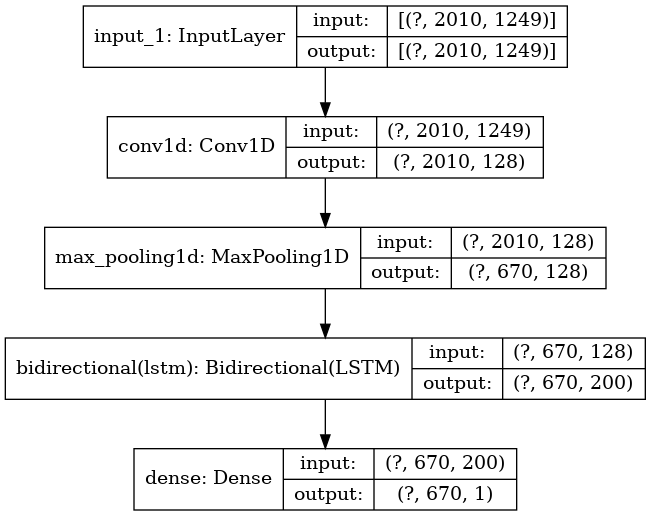

In [17]:
#architecture of the model
tf.keras.utils.plot_model(
    model, to_file='app_BRCA1.png', show_shapes=True, 
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

#model evaluation
y_pred = model(x_test).squeeze().detach().numpy()
model_evaluation_accuracy(y_test, y_pred)


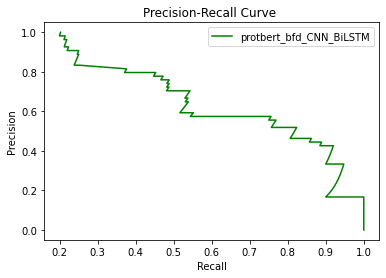

<Figure size 432x288 with 0 Axes>

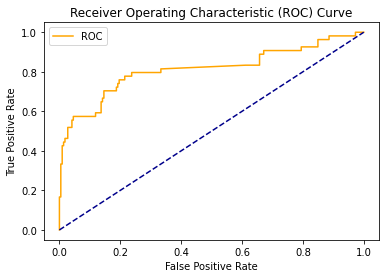

AUC Score: 0.81
 Test :  accuracy score : 0.88 - AUC score : 0.81  


<Figure size 432x288 with 0 Axes>

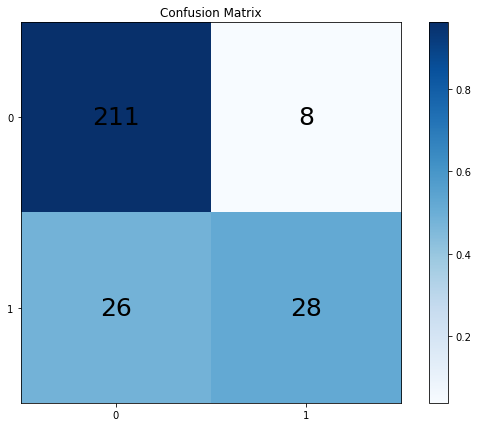

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       219
           1       0.78      0.52      0.62        54

    accuracy                           0.88       273
   macro avg       0.83      0.74      0.77       273
weighted avg       0.87      0.88      0.87       273



In [18]:
#model evaluation on test set
y_pred = model.predict(x_test)   
prediction=pd.DataFrame(y_pred.flatten()).rename(columns={0:'probability'}) #convert predictionss to dataframe
y_pred=prediction['probability']
#labels
y_test=y_test.astype(float).reshape(y_test.size,1) # convert numpy array elements from object to float for labels

prediction['targets']=pd.DataFrame(y_test) #convert labels from numpy array to DataFrame and convert elements from object to float
y_pred=prediction['probability']

y_true=prediction['targets']
#Plot Precision-Recall

# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

plt.figure()
plt.plot(precision, recall, color='green', label='protbert_bfd_CNN_BiLSTM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ')
plt.legend()
plt.show()
plt.savefig('PR_curve.png')
# Plot ROC_AUC

fpr, tpr, threshold = roc_curve(y_true, y_pred)
#roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
plt.savefig('ROC_curve.png')
auc = roc_auc_score(y_true, y_pred)
print('AUC Score: %.2f' % auc)
# Plot confusion matrix
model_evaluation_accuracy(y_true, y_pred)

confusion_matrix_plot(y_true, (y_pred> 0.5).astype(int), ["0", "1"])
matrix_index = ["0","1"]
from sklearn.metrics import classification_report 
y_pred= np.around(y_pred)
print(classification_report(y_true, y_pred,target_names=matrix_index))


0.0    219
1.0     54
Name: targets, dtype: int64

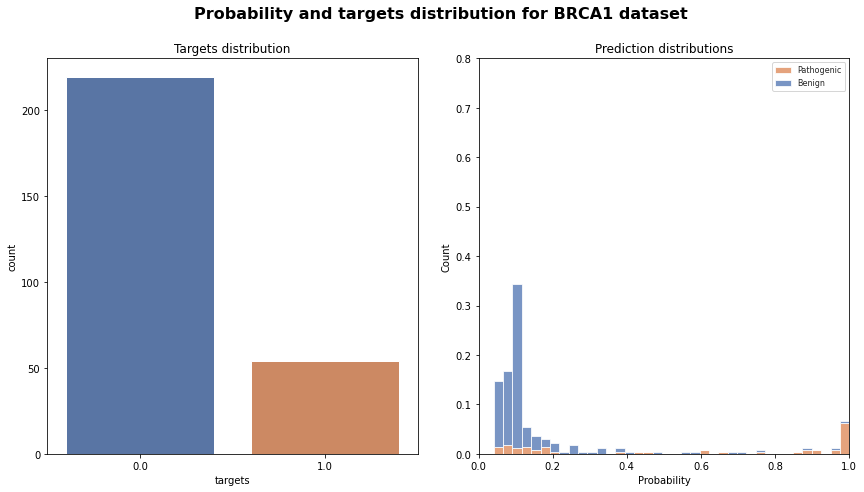

In [19]:
#Compare Predictions and targets distribution

fig, axes = plt.subplots(1, 2)
fig.suptitle('Probability and targets distribution for BRCA1 dataset', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(12)
axes[0].set_title('Targets distribution')
axes[1].set_title('Prediction distributions')


sns.set(font_scale=1.2)
sns.set_style("whitegrid")
plt.xlim(0, 1)
plt.ylim(0, 0.8)

plt.xlabel('Probability')
plt.ylabel('Count')

sns.histplot(ax=axes[1],data=prediction, x="probability", hue="targets", multiple="stack", stat='probability')
plt.legend(['Pathogenic', 'Benign'],loc='best', fontsize=8)

plt.tight_layout()
plt.figsize=(10,5)
sns.countplot(ax=axes[0],x=y_true)
y_true.value_counts()


**Run the application on PTEN dataset**

In [20]:
def create_dataset (file_path):
    data=pd.read_csv(file_path, header=None)
    data.columns = ['Data_{}'.format(int(i)+1) for i in data.columns]
    data.columns = [*data.columns[:-1], 'labels']
    return data
data = create_dataset('/home/k.benrayana/PathogenicAaMutations/data/Pten_dataset.csv') #PTEN dataset
data

,Data_1,Data_2,Data_3,Data_4,Data_5,Data_6,Data_7,Data_8,Data_9,Data_10,...,Data_395,Data_396,Data_397,Data_398,Data_399,Data_400,Data_401,Data_402,Data_403,labels
0,M,T,A,I,I,K,E,I,V,S,...,D,Q,H,T,Q,I,T,K,V,0
1,V,T,A,I,I,K,E,I,V,S,...,D,Q,H,T,Q,I,T,K,V,1
2,M,T,A,I,I,K,E,I,V,S,...,D,Q,H,T,Q,I,T,K,V,1
3,M,T,A,I,I,K,E,I,V,S,...,D,Q,H,T,Q,I,T,K,V,1
4,M,T,A,I,I,K,E,I,V,S,...,D,Q,H,T,Q,I,T,K,V,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,M,T,A,I,I,K,E,I,V,S,...,D,Q,H,T,Q,I,T,K,V,0
120,M,T,A,I,I,K,E,I,V,S,...,D,Q,H,T,Q,I,T,K,V,0
121,M,T,A,I,I,K,E,I,V,S,...,D,Q,H,T,Q,I,T,K,V,0
122,M,T,A,I,I,K,E,I,V,S,...,D,Q,H,T,Q,I,T,K,V,0


In [21]:
#prepare the sequences and labels

d = np.array(data)
sample_len = d.shape[0] # number of protein sequences in the whole dataset
time_len = d.shape[1]-1 #  length of the protein seq in the whole  dataset
#Hydrophilic coding vocabulary for hydrophobicity representation
vocab1 = {'A': 1.8, 'R':-4.5,'N':-3.5,'D':-3.5,'C':2.5,'Q':-3.5,'E':-3.5,'G':-0.4,'H' :-3.2,'I':4.5,
         'L':3.8,'K':-3.9,'M':1.9,'F':2.8,'P':-1.6,'S':-0.8,'T':-0.7,'W':-0.9,'Y':-1.3,'V':4.2,'X':-3.5,'*':-100}
#Mutation type Benign:0; Pathogenic:1
tags = {'0':0, '1':1}
#prepare data splits for embeddings + hydrophbicity index
data=np.array(data)
data_len = data.shape[0]
data_seqlen = data.shape[1] -1

sequences = data[:, 0:data_seqlen]
labels = data[:, data_seqlen]

#replace each Aa of sequences with hydrophobicity index
Aa_hydro = [[vocab1[word] for word in sentence] for sentence in sequences]
Aa_hydro = np.array(Aa_hydro).reshape(data_len,data_seqlen)
Aa_hydro
#Prepare labels reshape (data_len, 1)
labels = labels.reshape(data_len,1)
#compute embeddings of all sequences
transformer = BioTransformers(backend="protbert_bfd", device="cuda")
embeddings= transformer.compute_embeddings(sequences)["mean"]

/home/k.benrayana/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: device is deprecated; use num_gpus
Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████████████████| 124/124 [00:10<00:00, 12.35it/s]


In [22]:
labels

array([[0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [23]:
Aa_hydro

array([[ 1.9, -0.7,  1.8, ..., -0.7, -3.9,  4.2],
       [ 4.2, -0.7,  1.8, ..., -0.7, -3.9,  4.2],
       [ 1.9, -0.7,  1.8, ..., -0.7, -3.9,  4.2],
       ...,
       [ 1.9, -0.7,  1.8, ..., -0.7, -3.9,  4.2],
       [ 1.9, -0.7,  1.8, ..., -0.7, -3.9,  4.2],
       [ 1.9, -0.7,  1.8, ..., -0.7, -3.9,  4.2]])

In [24]:
embeddings

array([[ 0.0132907 ,  0.00634103,  0.01173088, ...,  0.00709186,
        -0.03873301,  0.00909076],
       [ 0.01762565,  0.0102506 ,  0.00428211, ...,  0.00443229,
        -0.03468812, -0.00014522],
       [ 0.01338098,  0.00762128,  0.01217768, ...,  0.00630828,
        -0.03999575,  0.0076549 ],
       ...,
       [ 0.01286589,  0.00789656,  0.01209296, ...,  0.00566767,
        -0.04019884,  0.00804778],
       [ 0.01286589,  0.00789656,  0.01209296, ...,  0.00566767,
        -0.04019884,  0.00804778],
       [ 0.01286589,  0.00789656,  0.01209296, ...,  0.00566767,
        -0.04019884,  0.00804778]], dtype=float32)

In [25]:
#embedding representation  with hydrophibicity encoder
sequences_hydro = np.concatenate((embeddings,Aa_hydro),axis=1)

In [26]:
sequences_hydro

array([[ 0.0132907 ,  0.00634103,  0.01173088, ..., -0.7       ,
        -3.9       ,  4.2       ],
       [ 0.01762565,  0.0102506 ,  0.00428211, ..., -0.7       ,
        -3.9       ,  4.2       ],
       [ 0.01338098,  0.00762128,  0.01217768, ..., -0.7       ,
        -3.9       ,  4.2       ],
       ...,
       [ 0.01286589,  0.00789656,  0.01209296, ..., -0.7       ,
        -3.9       ,  4.2       ],
       [ 0.01286589,  0.00789656,  0.01209296, ..., -0.7       ,
        -3.9       ,  4.2       ],
       [ 0.01286589,  0.00789656,  0.01209296, ..., -0.7       ,
        -3.9       ,  4.2       ]])

In [27]:
#split data 70% training set 15% validation set 15 % test or evaluation set
over = RandomOverSampler()  # balance training set
def split_dataset(sequences, labels):
    x_train, x_test, y_train, y_test = train_test_split(sequences, np.array(labels), test_size=0.15, random_state=1)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.176, random_state=2) 
    y_train=y_train.astype(float).reshape(y_train.size,1)
    y_test=y_test.astype(float).reshape(y_test.size,1)
    y_val=y_val.astype(float).reshape(y_val.size,1)
    x_train, y_train = over.fit_resample(x_train, y_train)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [28]:
#reshape final representation as an input for CNN/BiLSTM classifier i
def model_input(x_train, x_test, x_val):

    x_train=np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test=np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    x_val=np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))
    return x_train, x_test, x_val

In [29]:
x_train, y_train, x_test, y_test, x_val, y_val=split_dataset(sequences_hydro, labels) #split dataset to train/validation/test


In [30]:
 x_train, x_test, x_val=model_input(x_train, x_test, x_val)      #reshape final representation to 3D as an input for CNN/BiLSTM classifier 


In [31]:
#verify if the train set is balanced
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))


{0.0: 47, 1.0: 47}

In [32]:
#Classifier CNN/BiLSTM
input_shape = x_train.shape[2]   # shape of input: 1024 (protbert_bfd embeddings) + size of protein sequence (BRCA1: 225/PTEN: 403)
timesteps = x_train.shape[0] # number of protein sequences
model = Sequential()
model.add(InputLayer(input_shape=(timesteps, input_shape)))
model.add(Conv1D(filters=128, kernel_size=1, activation='relu')) # expected input data shape: (batch_size, timesteps, input_shape)
model.add(MaxPooling1D(pool_size=3, padding="same"))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dense(1, activation='sigmoid'))
bce_loss = tf.keras.losses.BinaryCrossentropy() #BCE loss function
accuracy = tf.keras.metrics.BinaryAccuracy() # Binary Accuracy (expressed in the [0,1] interval)
optimizer = tf.optimizers.Adam(learning_rate = 0.001) #Adam optimizer
model.compile(optimizer, bce_loss, accuracy)  
model.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=300, batch_size=32) #Training of the model

Epoch 1/300
3/3 [==============================] - 1s 241ms/step - loss: 0.8012 - binary_accuracy: 0.3936 - val_loss: 0.7069 - val_binary_accuracy: 0.3158
Epoch 2/300
3/3 [==============================] - 0s 9ms/step - loss: 0.6908 - binary_accuracy: 0.5745 - val_loss: 0.6380 - val_binary_accuracy: 0.6842
Epoch 3/300
3/3 [==============================] - 0s 9ms/step - loss: 0.6905 - binary_accuracy: 0.5319 - val_loss: 0.7418 - val_binary_accuracy: 0.3158
Epoch 4/300
3/3 [==============================] - 0s 9ms/step - loss: 0.7010 - binary_accuracy: 0.5000 - val_loss: 0.7096 - val_binary_accuracy: 0.3158
Epoch 5/300
3/3 [==============================] - 0s 9ms/step - loss: 0.6880 - binary_accuracy: 0.4787 - val_loss: 0.6618 - val_binary_accuracy: 0.6842
Epoch 6/300
3/3 [==============================] - 0s 9ms/step - loss: 0.6846 - binary_accuracy: 0.5532 - val_loss: 0.6771 - val_binary_accuracy: 0.6842
Epoch 7/300
3/3 [==============================] - 0s 9ms/step - loss: 0.6811 - 

3/3 [==============================] - 0s 9ms/step - loss: 0.6473 - binary_accuracy: 0.6064 - val_loss: 0.6716 - val_binary_accuracy: 0.6842
Epoch 55/300
3/3 [==============================] - 0s 9ms/step - loss: 0.6459 - binary_accuracy: 0.5851 - val_loss: 0.6689 - val_binary_accuracy: 0.6842
Epoch 56/300
3/3 [==============================] - 0s 9ms/step - loss: 0.6555 - binary_accuracy: 0.5638 - val_loss: 0.6581 - val_binary_accuracy: 0.6842
Epoch 57/300
3/3 [==============================] - 0s 9ms/step - loss: 0.6444 - binary_accuracy: 0.5745 - val_loss: 0.7084 - val_binary_accuracy: 0.3158
Epoch 58/300
3/3 [==============================] - 0s 9ms/step - loss: 0.6457 - binary_accuracy: 0.5213 - val_loss: 0.6847 - val_binary_accuracy: 0.7368
Epoch 59/300
3/3 [==============================] - 0s 9ms/step - loss: 0.6400 - binary_accuracy: 0.7021 - val_loss: 0.6571 - val_binary_accuracy: 0.6842
Epoch 60/300
3/3 [==============================] - 0s 8ms/step - loss: 0.6388 - binary_a

3/3 [==============================] - 0s 9ms/step - loss: 0.5742 - binary_accuracy: 0.7979 - val_loss: 0.6139 - val_binary_accuracy: 0.7368
Epoch 108/300
3/3 [==============================] - 0s 9ms/step - loss: 0.5767 - binary_accuracy: 0.6915 - val_loss: 0.6168 - val_binary_accuracy: 0.7368
Epoch 109/300
3/3 [==============================] - 0s 9ms/step - loss: 0.5598 - binary_accuracy: 0.7660 - val_loss: 0.6562 - val_binary_accuracy: 0.7895
Epoch 110/300
3/3 [==============================] - 0s 9ms/step - loss: 0.5514 - binary_accuracy: 0.8085 - val_loss: 0.6171 - val_binary_accuracy: 0.7368
Epoch 111/300
3/3 [==============================] - 0s 9ms/step - loss: 0.5411 - binary_accuracy: 0.8085 - val_loss: 0.6357 - val_binary_accuracy: 0.7368
Epoch 112/300
3/3 [==============================] - 0s 9ms/step - loss: 0.5405 - binary_accuracy: 0.9043 - val_loss: 0.5926 - val_binary_accuracy: 0.7368
Epoch 113/300
3/3 [==============================] - 0s 9ms/step - loss: 0.5495 - bi

Epoch 160/300
3/3 [==============================] - 0s 9ms/step - loss: 0.4737 - binary_accuracy: 0.8191 - val_loss: 0.5992 - val_binary_accuracy: 0.7895
Epoch 161/300
3/3 [==============================] - 0s 9ms/step - loss: 0.4674 - binary_accuracy: 0.8511 - val_loss: 0.5729 - val_binary_accuracy: 0.7368
Epoch 162/300
3/3 [==============================] - 0s 9ms/step - loss: 0.4709 - binary_accuracy: 0.7979 - val_loss: 0.6039 - val_binary_accuracy: 0.7895
Epoch 163/300
3/3 [==============================] - 0s 8ms/step - loss: 0.4927 - binary_accuracy: 0.7447 - val_loss: 0.5714 - val_binary_accuracy: 0.7368
Epoch 164/300
3/3 [==============================] - 0s 9ms/step - loss: 0.5761 - binary_accuracy: 0.7128 - val_loss: 0.6443 - val_binary_accuracy: 0.8947
Epoch 165/300
3/3 [==============================] - 0s 9ms/step - loss: 0.5213 - binary_accuracy: 0.6809 - val_loss: 0.5748 - val_binary_accuracy: 0.7368
Epoch 166/300
3/3 [==============================] - 0s 9ms/step - los

Epoch 213/300
3/3 [==============================] - 0s 8ms/step - loss: 0.5155 - binary_accuracy: 0.7128 - val_loss: 0.6131 - val_binary_accuracy: 0.7368
Epoch 214/300
3/3 [==============================] - 0s 9ms/step - loss: 0.4701 - binary_accuracy: 0.7128 - val_loss: 0.7528 - val_binary_accuracy: 0.2632
Epoch 215/300
3/3 [==============================] - 0s 9ms/step - loss: 0.4711 - binary_accuracy: 0.7872 - val_loss: 0.6271 - val_binary_accuracy: 0.7368
Epoch 216/300
3/3 [==============================] - 0s 9ms/step - loss: 0.4783 - binary_accuracy: 0.7872 - val_loss: 0.7761 - val_binary_accuracy: 0.2632
Epoch 217/300
3/3 [==============================] - 0s 9ms/step - loss: 0.5220 - binary_accuracy: 0.7021 - val_loss: 0.5755 - val_binary_accuracy: 0.7368
Epoch 218/300
3/3 [==============================] - 0s 9ms/step - loss: 0.4178 - binary_accuracy: 0.8085 - val_loss: 0.7435 - val_binary_accuracy: 0.2632
Epoch 219/300
3/3 [==============================] - 0s 9ms/step - los

Epoch 266/300
3/3 [==============================] - 0s 9ms/step - loss: 0.3802 - binary_accuracy: 0.8404 - val_loss: 0.5635 - val_binary_accuracy: 0.7895
Epoch 267/300
3/3 [==============================] - 0s 8ms/step - loss: 0.3799 - binary_accuracy: 0.8830 - val_loss: 0.5615 - val_binary_accuracy: 0.7368
Epoch 268/300
3/3 [==============================] - 0s 8ms/step - loss: 0.4062 - binary_accuracy: 0.7872 - val_loss: 0.6247 - val_binary_accuracy: 0.8421
Epoch 269/300
3/3 [==============================] - 0s 9ms/step - loss: 0.4248 - binary_accuracy: 0.8830 - val_loss: 0.5605 - val_binary_accuracy: 0.7368
Epoch 270/300
3/3 [==============================] - 0s 9ms/step - loss: 0.3699 - binary_accuracy: 0.8936 - val_loss: 0.5813 - val_binary_accuracy: 0.7895
Epoch 271/300
3/3 [==============================] - 0s 9ms/step - loss: 0.4902 - binary_accuracy: 0.7872 - val_loss: 0.5693 - val_binary_accuracy: 0.7895
Epoch 272/300
3/3 [==============================] - 0s 9ms/step - los

In [33]:
#architecture of the model

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 94, 128)           182784    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32, 200)           183200    
_________________________________________________________________
dense_1 (Dense)              (None, 32, 1)             201       
Total params: 366,185
Trainable params: 366,185
Non-trainable params: 0
_________________________________________________________________


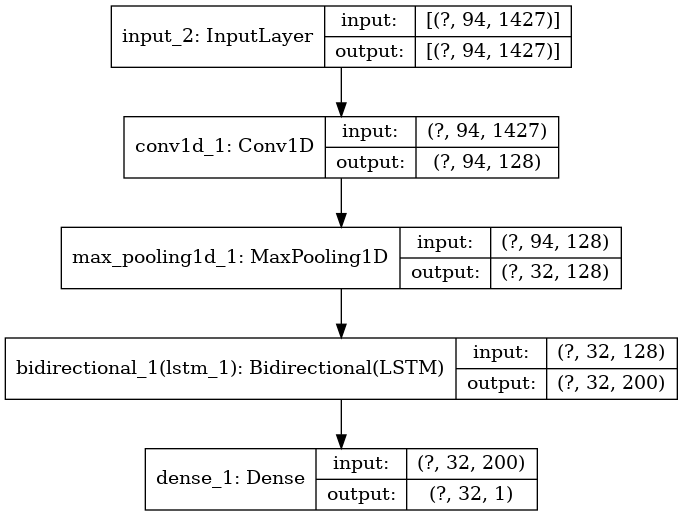

In [34]:
#architecture of the model
tf.keras.utils.plot_model(
    model, to_file='app_BRCA1.png', show_shapes=True, 
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

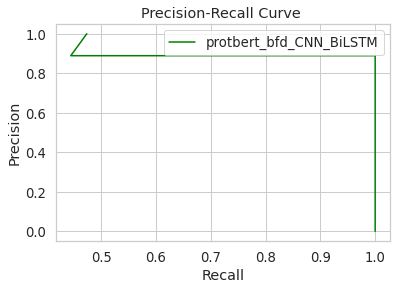

<Figure size 432x288 with 0 Axes>

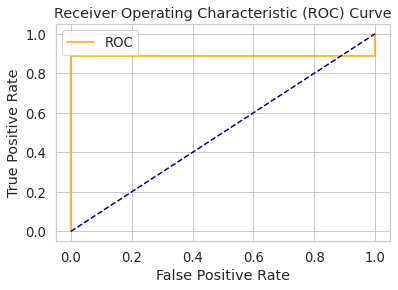

AUC Score: 0.89
 Test :  accuracy score : 0.79 - AUC score : 0.89  


<Figure size 432x288 with 0 Axes>

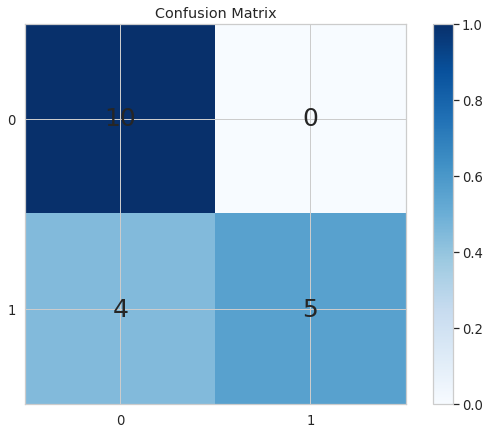

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       1.00      0.56      0.71         9

    accuracy                           0.79        19
   macro avg       0.86      0.78      0.77        19
weighted avg       0.85      0.79      0.78        19



In [35]:
#model evaluation on test set
y_pred = model.predict(x_test)   
prediction=pd.DataFrame(y_pred.flatten()).rename(columns={0:'probability'}) #convert predictionss to dataframe
y_pred=prediction['probability']
#labels
y_test=y_test.astype(float).reshape(y_test.size,1) # convert numpy array elements from object to float for labels

prediction['targets']=pd.DataFrame(y_test) #convert labels from numpy array to DataFrame and convert elements from object to float
y_pred=prediction['probability']

y_true=prediction['targets']
#Plot Precision-Recall

# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

plt.figure()
plt.plot(precision, recall, color='green', label='protbert_bfd_CNN_BiLSTM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ')
plt.legend()
plt.show()
plt.savefig('PR_curve.png')
# Plot ROC_AUC

fpr, tpr, threshold = roc_curve(y_true, y_pred)
#roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
plt.savefig('ROC_curve.png')
auc = roc_auc_score(y_true, y_pred)
print('AUC Score: %.2f' % auc)
# Plot confusion matrix
model_evaluation_accuracy(y_true, y_pred)

confusion_matrix_plot(y_true, (y_pred> 0.5).astype(int), ["0", "1"])
matrix_index = ["0","1"]
from sklearn.metrics import classification_report 
y_pred= np.around(y_pred)
print(classification_report(y_true, y_pred,target_names=matrix_index))


0.0    10
1.0     9
Name: targets, dtype: int64

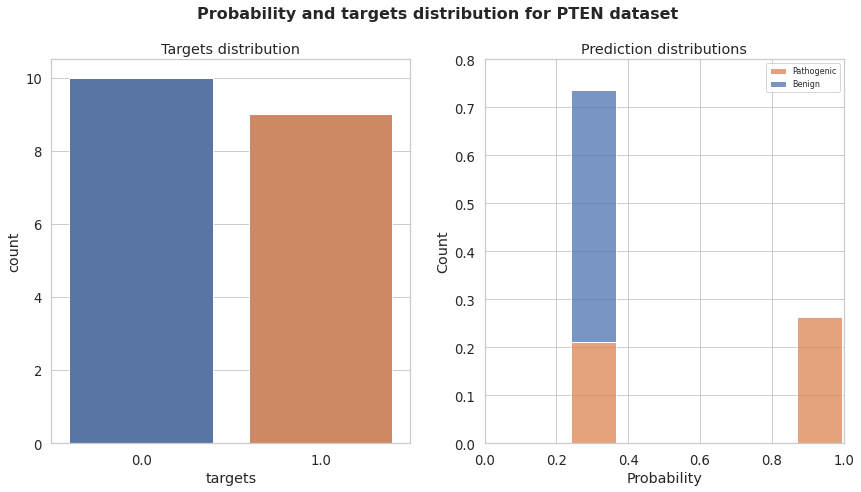

In [36]:
#compare Predictions and targets distribution

fig, axes = plt.subplots(1, 2)
fig.suptitle('Probability and targets distribution for PTEN dataset', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(12)
axes[0].set_title('Targets distribution')
axes[1].set_title('Prediction distributions')


sns.set(font_scale=1.2)
sns.set_style("whitegrid")
plt.xlim(0, 1)
plt.ylim(0, 0.8)

plt.xlabel('Probability')
plt.ylabel('Count')

sns.histplot(ax=axes[1],data=prediction, x="probability", hue="targets", multiple="stack", stat='probability')
plt.legend(['Pathogenic', 'Benign'],loc='best', fontsize=8)

plt.tight_layout()
plt.figsize=(10,5)
sns.countplot(ax=axes[0],x=y_true)
y_true.value_counts()
